# CLASIFICACIÓN DE MENSAJES DE TEXTO CON NAIVE BAYES

## Objetivo

Aplicar técnicas de ciencia de datos sobre mensajes de una lista de correos electrónicos clasificada por categorías, y generar un modelo que pueda predecir la categoría a la que pertenece un mensaje dado.

## Conjunto de datos

El conujunto de datos se extrajo de la lista de correos de debian, de los años 2018 y 2019 de las categorías: `debian-cli debian-jobs debian-r debian-desktop debian-mirrors debian-firewall debian-legal debian-edu debian-python debian-vote`.

El conjunto de datos se puede descargar en: http://misc_publico.rmgss.net/varios/MCD/tests/NaiveBayesText/debian-mailinglist.csv

Los mensajes de la lista de correos se guardaron en el archivo `debian-mailinglist.csv` usando la herramienta https://github.com/strymsg/mailinglist-downloader-pyhttps://github.com/strymsg/mailisting-downloader-py.

In [166]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [167]:
data = pd.read_csv('debian-mailinglist.csv', encoding='utf-8')
data.head()

category  year  month  \
0  debian-jobs  2018      6   
1  debian-jobs  2018      9   
2  debian-jobs  2018     12   
3  debian-jobs  2018     10   
4  debian-jobs  2018      3   

                                             message format  
0  Hello All --\n\nCanonical is hiring for the Ub...  plain  
1  Hi!\n\nMy company SUSE is looking for a softwa...  plain  
2  We’re looking for a Linux systems engineer for...  plain  
3  Hello,\n\nFreexian (my company) is doing rathe...  plain  
4  This job offer looks for a german (and english...  plain

In [168]:
data.groupby('category').describe().head(5)

year                                                 \
                  count         mean       std     min     25%     50%   
category                                                                 
debian-cli          7.0  2018.142857  0.377964  2018.0  2018.0  2018.0   
debian-desktop    177.0  2018.632768  0.483418  2018.0  2018.0  2019.0   
debian-edu       2021.0  2018.518555  0.499779  2018.0  2018.0  2019.0   
debian-firewall    20.0  2018.450000  0.510418  2018.0  2018.0  2018.0   
debian-jobs        37.0  2018.324324  0.474579  2018.0  2018.0  2018.0   

                                  month                                        \
                    75%     max   count       mean       std  min   25%   50%   
category                                                                        
debian-cli       2018.0  2019.0     7.0  10.571429  2.992053  4.0  11.0  12.0   
debian-desktop   2019.0  2019.0   177.0   5.796610  3.049476  1.0   4.0   5.0   
debian-edu       2019.0  2019.0  2021.0   6.121227  3.610168  1.0   3.0   6.0   
debian-firewall  2019.0  2019.0    20.0   5.850000  4.380279  1.0   2.0   3.5   
debian-jobs      2019.0  2019.0    37.0   6.324324  3.472544  1.0   3.0   6.0   

                              
                   75%   max  
category                      
debian-cli       12.00  12.0  
debian-desktop    9.00  12.0  
debian-edu       10.00  12.0  
debian-firewall  10.25  12.0  
debian-jobs       9.00  12.0

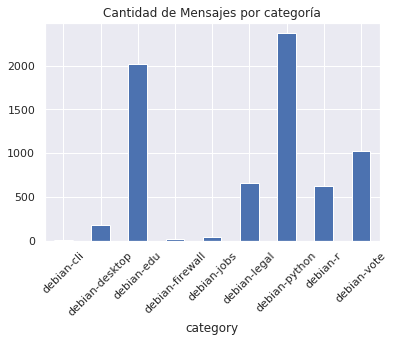

In [169]:
data.groupby('category')['category'].count().plot.bar(title='Cantidad de Mensajes por categoría', rot=45)

Text(0.5, 1.0, 'Mensajes en categorías por año')

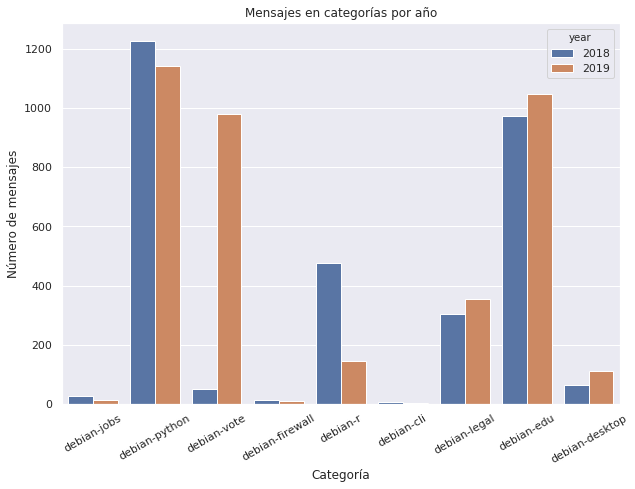

In [170]:
plt.figure(figsize=(10,7))
g = sns.countplot(x='category', hue='year', data=data)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.ylabel('Número de mensajes')
plt.xlabel('Categoría')
g.set_title("Mensajes en categorías por año")

In [171]:
# Longitud promedio de mensajes por categoria
dt1 = data.copy()
# dt1['message'] = dt1['message'].values.astype('U')
dt1['message'] = data['message'].astype(str)
dt1['length'] = dt1['message'].apply(len)

[Text(0, 0, 'debian-jobs'),
 Text(0, 0, 'debian-python'),
 Text(0, 0, 'debian-vote'),
 Text(0, 0, 'debian-firewall'),
 Text(0, 0, 'debian-r'),
 Text(0, 0, 'debian-cli'),
 Text(0, 0, 'debian-legal'),
 Text(0, 0, 'debian-edu'),
 Text(0, 0, 'debian-desktop')]

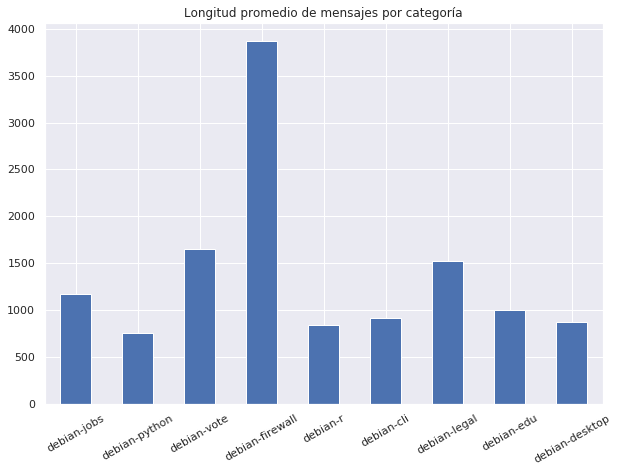

In [172]:
dt1[dt1['category'] == 'debian-python']['length'].mean()
dict = {}
for cat in dt1['category'].unique():
    dict[cat] = int(dt1[dt1['category'] == cat]['length'].mean())
dict
#dtf1 = pd.DataFrame.from_dict(dict)
ss1 = pd.Series(dict)
plt.figure(figsize=(10,7))
g = ss1.plot(kind='bar')
g.set_title('Longitud promedio de mensajes por categoría')
g.set_xticklabels(g.get_xticklabels(), rotation=30)

## Análisis exploratorio de datos (EDA)

In [173]:
print(data.shape)
print(data['message'][10][:150])

(6945, 5)
\n<div dir="ltr">A contact that I&#39;ve actually not worked for before is asking for someone to port a VxWorks board support package to Linux.<div><b


In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 5 columns):
category    6945 non-null object
year        6945 non-null int64
month       6945 non-null int64
message     6923 non-null object
format      6945 non-null object
dtypes: int64(2), object(3)
memory usage: 271.4+ KB


In [175]:
print('categories:', data['category'].unique())
print('years:', data['year'].unique())
print('months:', data['month'].unique())

categories: ['debian-jobs' 'debian-python' 'debian-vote' 'debian-firewall' 'debian-r'
 'debian-cli' 'debian-legal' 'debian-edu' 'debian-desktop']
years: [2018 2019]
months: [ 6  9 12 10  3  8  5  7  1  2 11  4]


Por ser mensajes de correo electrónico, algunos de estos tienen en el mensaje un bloque con la firma digital, por ejemplo:
```
-----BEGIN PGP SIGNATURE-----

iQFUBAEBCAA+FiEEVZrkbC1rbTJl58uh4+M5I0i1DTkFAl3o8RwgHGlqYWNrc29u
QGNoaWFyay5ncmVlbmVuZC5vcmcudWsACgkQ4+M5I0i1DTlHdAf+JAAuZLrEmzDg
xgFlIKK7nxGabVx1j1LDbP7xnyCv2HOOI9KQfONE/zeuRu4+r2OHNC131LXDl1Om
9pS1N3bQrW5OfQQTHvU+ESM8J+H1UT6EPAZEkNkkDoKTdvlA0NB47pfWjYY5o8tB
T4LkXLcMkccPypOcNjVTN6hbzyL/Krw4CTbkJHSxD3tCRW+nLMLLDLVdAgdE9DMG
gONiU2XE4LonyVhOysWjTDTDYOKpyq0Jo3UmQsf2mrF0cNH3tQDuRpdLZJeb9W1e
hhGdsJmp912oRLyrhGLxqvfOnxWHFp/y4kwKShSAcCfEKeievz+4gLeunYMZDOf8
wHeOyLQSOg==
=l2yV
-----END PGP SIGNATURE-----
```
Este bloque es único por mensaje y no ayuda en el análisis ni para los algoritmos entrenamiento, por lo que se descartan estos bloques de cada mensaje.

In [176]:
messages_cp = []
c = 0
for i in range(len(data['message'])):
    mensaje = data['message'][i]
    try:
        bi = mensaje.index('-----BEGIN PGP SIGNATURE-----')
        be = mensaje.index('-----END PGP SIGNATURE-----')
        nmensaje = mensaje[:bi] + mensaje[be + 28:]
        messages_cp.append(nmensaje)
        c +=1
        #print('procesado mensaje i:', i, len(mensaje), len(nmensaje))
    except Exception as e:
        messages_cp.append(mensaje)
        pass
data['message'] = messages_cp
print('procesados:', c)

procesados: 275


Los mensajes en la lista de correos también están en formato **html** y es necesario limpiar las etiquetas como `<div> <a> ... etc` para solo quedarse con el texto

In [177]:
import re

def cleanHTMLTags(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# aplica la funcion cleanHTMLTags solo a las filas con formato html
data.loc[data['format'] == 'html', 'message'] = data.loc[data['format'] == 'html']['message'].apply(cleanHTMLTags)

print(data['message'][10][:150],'\n---')
print(data['message'][12][:150])

\nA contact that Ive actually not worked for before is asking for someone to port a VxWorks board support package to Linux.Work in Poway, CA (San Dieg 
---
Hi,

would you like to become my colleague? conova communications Gmbh in
Salzburg/Austria is hiring again.

As speaking at least a few bits of German


Para tener una mejor generalización se convierten todas las palabras a minúsculas por ejemplo "Hello I'm here" a "hello i'm here" aplicando una normalización similar a ([este ejemplo](https://medium.com/analytics-vidhya/randomforest-classifier-vs-multinomial-naive-bayes-for-a-multi-output-natural-language-2426381a5217))

In [178]:
data['message'] = data['message'].astype('U').str.lower()
data['message'][90][:150]

'\\nhi,2018-02-24 19:13 gmt+01:00 stefano rivera stefanor@debian.org:ive finished migrating papt to salsa\\nhttps://salsa.debian.org/python-team/applicat'

También se eliminan las palabras que no aportan a la clasificación, por ejemplo palabras comunes en inglés como `a he due its more one while former has no, etc`. Este conjunto de palabras se define como **stop_words** que luego se incluye en `CountVectorizer` como parámetro para ser ignoradas.

In [179]:
from sklearn.feature_extraction import text
import string
stop_words=text.ENGLISH_STOP_WORDS
# Quitando puntuacion y stop words
def remove_puntuation_and_stop_words(texto):
    '''
    Esta funcion se aplicaria tambien para eliminar simbolos de puntuacion
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    
    #1
    nopunc = [char for char in texto if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    stop_words=text.ENGLISH_STOP_WORDS
    clean_words = [word for word in nopunc.split() if word.lower() not in stop_words]
    #3
    return ' '.join(clean_words)

def remove_stopwords(texto):
    clean_words = [word for word in texto.split() if word.lower() not in stop_words]
    return ' '.join(clean_words)

#data['message'] = data['message'].apply(process_text)
data['message'] = data['message'].apply(remove_stopwords)
data['message'][40]

'\\nhi,good news everyone. migrated dpmt salsa.what done:git repository migration alioth - salsagit alioth locked (pre-receive hook)dd members alioth dpmt team migrated salsa dpmt subgroupdd members alioth papt team migrated salsa papt subgrouporiginal owners dpmt+papt owners salsa python team (parent dpmt papt)aliothrewriter (only http/https). example url:&#xa0;https://anonscm.debian.org/cgit/python-modules/packages/enum34.git redirect salsaenable irc notification, tag bug pending hook email notifications to&#xa0;dispatch@tracker.debian.orgall non-dd members needs create account salsa request access. send request (with username) private mail me. member dpmt/papt alioth group, add salsa.you change git remotes salsa.simple workaround like debcheckout:onovy@sid:~$ cat ~/.gitconfig...[url ssh://git@salsa.debian.org/python-team/modules/]&#xa0; &#xa0; insteadof = git://anonscm.debian.org/python-modules/packages/&#xa0; &#xa0; insteadof = git://git.debian.org/python-modules/packages/&#xa0; &#

In [180]:
df_x=data['message']
print(df_x.head(5))
df_y=data['category']
print(df_y.head(5))

0    hello -- canonical hiring ubuntu server team. ...
1    hi! company suse looking software engineer wor...
2    we’re looking linux systems engineer capacity ...
3    hello, freexian (my company) doing i'm looking...
4    job offer looks german (and english) speaking ...
Name: message, dtype: object
0    debian-jobs
1    debian-jobs
2    debian-jobs
3    debian-jobs
4    debian-jobs
Name: category, dtype: object


In [181]:
def modelAndTestAcurracyMultinomialNB(dataset, stop_words=[], train_size=0.60, test_size=0.35, seed=0):
    df_x=dataset['message']
    df_y=dataset['category']
    # Aplicando label encoder a categorias
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(df_y)
    
    # dividiendo en train y test
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=test_size, train_size=train_size, random_state=seed) # dejando el resto para pruebas posteriores

    cv1 = CountVectorizer(decode_error='ignore',
                          min_df=0.004, # ignorar palabras con ocurrencia menor a 0.4%
                          stop_words=stop_words)
    x_traincv = cv1.fit_transform(x_train.values.astype('U')) # importante values.astype('U')
    
    x_testcv=cv1.transform(x_test.values.astype('U'))

    # print('vocabulary:', cv1.vocabulary_['hi'], cv1.vocabulary_['water'])

    # Vocabulario inverso para obtener las palabras dada la prediccion
    # Solucion extraida de https://stackoverflow.com/questions/41649968/how-to-vectorize-and-devectorize-using-sklearns-countvectorizer
    terms = np.array(list(cv1.vocabulary_.keys()))
    # print('terms', terms[0:10])
    indices = np.array(list(cv1.vocabulary_.values()))
    # print('indices', indices[0:10])
    inverse_vocabulary = terms[np.argsort(indices)]
    # print('inverse voc', len(inverse_vocabulary), inverse_vocabulary[4000:4010])

    mnb = MultinomialNB()
    y_train = y_train.astype('int')
    
    mnb.fit(x_traincv, y_train)
    
    # obteniendo predicciones
    predictions=mnb.predict(x_testcv)

    # print('len predictions', len(predictions), len(x_traincv))
    # probando precision

    # para mostrar las etiquetas de las predicciones
    y_predicted_labels = labelencoder_y.inverse_transform(predictions)
    categories = pd.Series(y_predicted_labels).unique()
    # diccionario para mostrar aciertos y errores en las predicciones por categorias
    results_category = {}
    for cat in categories:
        results_category[cat] = [0, 0]

    a=np.array(y_test)
    count=0
    for i in range(len(predictions)):
        if predictions[i] == a[i]: # acierto
            results_category[y_predicted_labels[i]][0] += 1
            count = count+1
        else: # error
            results_category[y_predicted_labels[i]][1] += 1
        # para mostrar algunos resultados
        # if i%653 == 1 and i < len(inverse_vocabulary):
        #     print(predictions[i],':', inverse_vocabulary[i], '>\t\t' , y_predicted_labels[i])
    results_categories = {}
    for key, value in results_category.items():
        results_categories[key] = value[0] / (value[0] + value[1])
    print('accurracy:', accuracy_score(y_test, predictions))
    # print('successful predicted:', count, 'of', str(len(predictions)))
    # print('acurracy:', str(count/len(predictions)))
    return ((x_traincv, cv1, y_train),
            count/len(predictions), # resultados
            results_categories) # resultados por categorias

In [182]:
# probando MultinomialNB
print('========= MultinomialNB predictions ==============')
trains = []
accuracies = []
results_categories = []
for i in range(0, 20):
    print('\nEntrenamiento', i)
    train, accuracy, results = modelAndTestAcurracyMultinomialNB(data,
                                                                 stop_words=stop_words,
                                                                 seed=random.randint(0,100))
    accuracies.append(accuracy)
    trains.append(train)
    results_categories.append(results)

========= MultinomialNB predictions ==============

Entrenamiento 0


accurracy: 0.8959276018099548

Entrenamiento 1


accurracy: 0.8996297819827231

Entrenamiento 2


accurracy: 0.8914027149321267

Entrenamiento 3


accurracy: 0.888523241464418

Entrenamiento 4


accurracy: 0.8918140682846565

Entrenamiento 5


accurracy: 0.8909913615795969

Entrenamiento 6


accurracy: 0.8922254216371863

Entrenamiento 7


accurracy: 0.8967503085150144

Entrenamiento 8


accurracy: 0.8946935417523653

Entrenamiento 9


accurracy: 0.8988070752776635

Entrenamiento 10


accurracy: 0.8979843685726039

Entrenamiento 11


accurracy: 0.8996297819827231

Entrenamiento 12


accurracy: 0.8897573015220074

Entrenamiento 13


accurracy: 0.8918140682846565

Entrenamiento 14


accurracy: 0.9016865487453722

Entrenamiento 15


accurracy: 0.8988070752776635

Entrenamiento 16


accurracy: 0.8963389551624846

Entrenamiento 17


accurracy: 0.8946935417523653

Entrenamiento 18


accurracy: 0.8983957219251337

Entrenamiento 19


accurracy: 0.8844097079391197


MEAN: 0.8947141094199917


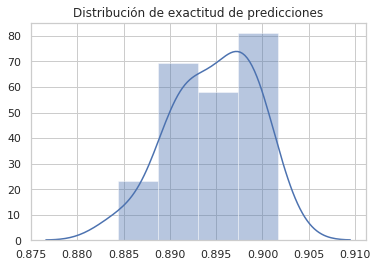

MEAN: 0.8947141094199917


In [183]:
# Graficando resultados
nda = np.array(accuracies)
print('MEAN:', nda.mean())
sns.set(style="whitegrid")
sns.distplot(nda)
plt.title('Distribución de exactitud de predicciones')
plt.show()
# sns.boxplot(x=nda)
nda = np.array(accuracies)
sns.set(style="whitegrid")
plt.title('Distribución de exactitud de predicciones')
sns.boxplot(x=nda)
plt.show()
print('MEAN:', nda.mean())

### Conclusiones

Después de entrenar 20 veces usando la técnica NaiveBayes Multinomial, se alcanza una precisión promedio de **0.8944** clasificando los mensajes de acuerdo a las categorías en las lista de correos de debian.

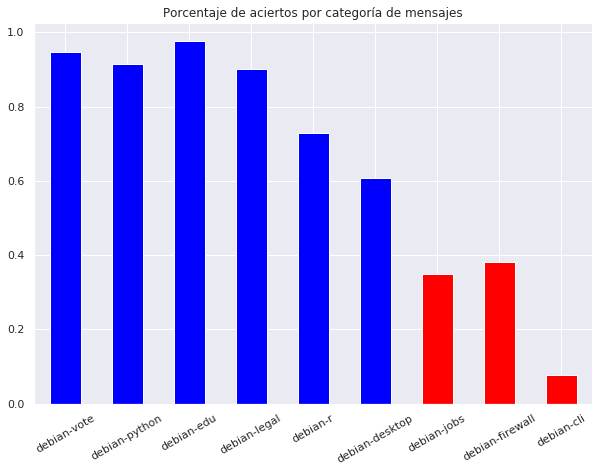

In [184]:
# Mostrando porcentaje de aciertos por categorias
sns.set()
clrs = ['red' if (x < 0.51) else 'blue' for x in pd.DataFrame(results_categories).mean().values ]
plt.figure(figsize=(10,7))
g = pd.DataFrame(results_categories).mean().plot.bar(color=clrs)
g.set_title('Porcentaje de aciertos por categoría de mensajes')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

Analizando el porcentaje de aciertos por categorías, se puede ver que no se tienen buenas predicciones para `debian-jobs debian-firewall debian-cli`. La razón principal puede ser que estas categorías tiene pocos mensajes con debian-jobs y debian-firewall por debajo de 100 mensajes. Para todas las demás categorías con al menos 500 mensajes se tienen predicciones con una exactitud por encima de 0.51, siendo las mejores para `debian-edu debian-legal debian-vote` siendo también estas las categorías con las que más mensajes se cuenta cada una con más de 1000 mensajes.

También estas tres mejores categorías son las que tienen los mensajes con menos contenido técnico, es decir se usa lenguaje común y se repiten más las palabras.

Los resultados muestran la efectividad de la técnica Naive Bayes Multinomial para la clasificación de mensajes de correos electrónicos según categorías. Sin embargo, para un análisis más preciso se requieren tomar en cuenta más mensajes y hacer una mayor limpieza en el contenido técnico de los mensajes. Puede ser necesario probar las predicciones directamente con mensajes de otros años por ejemplo 2015 y 2016 luego de hacer el entrenamiento y analizar si el modelo no se ha ajustado demasiado bien.